# DengueAI - Time-lagged features

*Anders Poirel - 14-05-2020*

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,PolynomialFeatures
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.model_selection import (cross_validate, TimeSeriesSplit)

Figure prettyfying:

In [3]:
mpl.rcParams['figure.dpi']= 150
sns.set()

## Reading data

In [4]:
RAW_DATA_PATH = '../data/raw'
PROCESSED_DATA_PATH = '../data/processed'

In [31]:
train_features = pd.read_csv(os.path.join(RAW_DATA_PATH, "dengue_features_train.csv"))
train_labels = pd.read_csv(os.path.join(RAW_DATA_PATH, "dengue_labels_train.csv"))
test_features = pd.read_csv(os.path.join(RAW_DATA_PATH, "dengue_features_test.csv"))

## Feature engineering

- backfill missing features
- combine east and west vegetation indices
- drop correlated and unused columns

In [6]:
train = (train_features
    .drop( # correlated features
        ['reanalysis_sat_precip_amt_mm', 'reanalysis_dew_point_temp_k', 
         'reanalysis_air_temp_k', 'reanalysis_tdtr_k'],
        axis = 1
    )
    .fillna(method = 'backfill')
    .assign(
        ndvi_n = lambda x : x['ndvi_ne'] + x['ndvi_nw'] / 2,
        ndvi_s = lambda x : x['ndvi_se'] + x['ndvi_sw'] / 2,
        monthofyear = lambda x: pd.to_datetime(x['week_start_date']).dt.month
    )
    .drop( # unused features
        ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'year', 'weekofyear',
         'week_start_date'], 
        axis = 1
    )
)

Select features that we want to shift

In [7]:
ts_features = list(
    train.loc[:, 'precipitation_amt_mm' : 'ndvi_s'].columns.values
)

Split data between San Juan and Iquitos

In [8]:
train_sj = train[train['city'] == 'sj'].drop('city', axis = 1)
train_iq = train[train['city'] == 'iq'].drop('city', axis = 1)

Function for adding time-lagged features to dataframe

In [9]:
def add_lagged_features(df, max_lag, features):
    lag_df = [
        df[features].shift(k).add_prefix('lag' + str(k) + '_')
        for k in range(1, max_lag+1)
    ]
    return pd.concat([df] + lag_df, axis = 1)

Add the lagged features to each dataframe. As before, we fill crudely
using `method = 'backfill'`, though a more sophisticated approach would be 
preferred

In [10]:
train_sj = add_lagged_features(train_sj, 7, ts_features).fillna(method = 'backfill')
train_iq = add_lagged_features(train_iq, 7, ts_features).fillna(method = 'backfill')

In [11]:
full_features = list(train_sj.columns.values)

## Writing the files

In [12]:
train_sj.to_csv(os.path.join(PROCESSED_DATA_PATH, 'train_sj.csv'), index = False)
train_iq.to_csv(os.path.join(PROCESSED_DATA_PATH, 'train_iq.csv'), index = False)

## Model

We want the ratio of data in each city to the full dataset to compute 
combined average CV scores

In [13]:
sj_ratio = len(train_sj) / len(train)
iq_ratio = len(train_iq) / len(train)

We need different pipelines for our date-related features and the other numerical
features

In [14]:
categorical_features = ['monthofyear']

In [15]:
numerical_features = list(train_sj.columns.values)
numerical_features.remove('monthofyear')

In [16]:
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder())
])

In [17]:
numerical_transformer = Pipeline([
    ('scale', StandardScaler()),
#    ('poly', PolynomialFeatures(2))
])

In [18]:
preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)
])

### San Juan

In [19]:
y_train_sj = train_labels[train_labels['city'] == 'sj']['total_cases']

In [20]:
model_sj = Pipeline([
    ('pre', preprocessor),
    ('lasso', Lasso(alpha = 9.8))
])

In [21]:
cv_res_sj = cross_validate(
    estimator = model_sj,
    X = train_sj,
    y = y_train_sj,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
sj_score = np.mean(cv_res_sj['test_score'])
sj_score

-30.727359443621957

Lasso $\alpha \approx 9$ seems to be a good parameter, with better CV scores than
our results using fbprophet.

#### Visualization

In [22]:
model_sj.fit(train_sj, y_train_sj)
y_val_sj = model_sj.predict(train_sj)

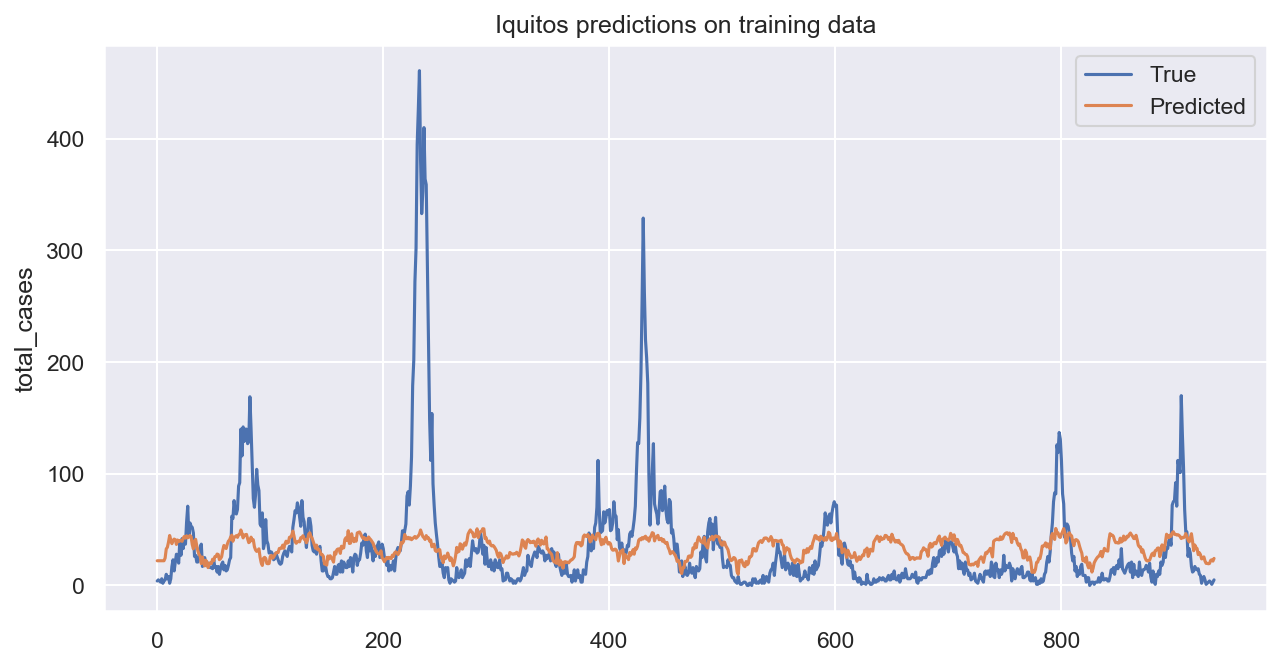

In [23]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = y_train_sj, x = train_sj.index.values, ax = ax)
sns.lineplot(y = y_val_sj, x = train_sj.index.values, ax = ax)
ax.set(title = 'Iquitos predictions on training data')
ax.legend(['True', 'Predicted'])

As in all other attempts, the model does not seem to be able to capture the large peaks in cases, even though it does a good job of learning the overall seasonality

### Iquitos

In [24]:
y_train_iq = train_labels[train_labels['city'] == 'iq']['total_cases']

In [25]:
model_iq = Pipeline([
    ('pre', preprocessor),
    ('lasso', Lasso(alpha = 1))
])

In [26]:
cv_res_iq = cross_validate(
    estimator = model_iq,
    X = train_iq,
    y = y_train_iq,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
iq_score = np.mean(cv_res_iq['test_score'])
iq_score

-6.5842494513551895

#### Visualization

In [27]:
model_iq.fit(train_iq, y_train_iq)
y_val_iq = model_iq.predict(train_iq)

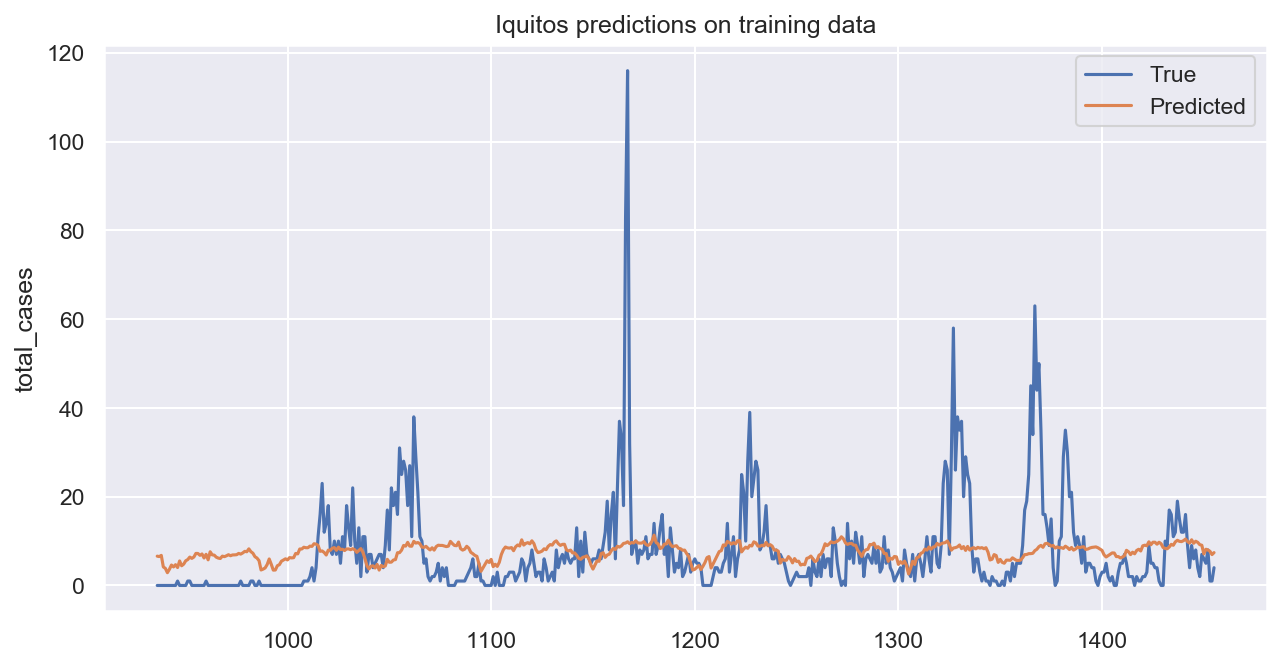

In [28]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = y_train_iq, x = train_iq.index.values, ax = ax)
sns.lineplot(y = y_val_iq, x = train_iq.index.values, ax = ax)
ax.set(title = 'Iquitos predictions on training data')
ax.legend(['True', 'Predicted'])

### Overall CV result

In [29]:
sj_ratio * sj_score + iq_ratio * iq_score

-22.104820160669544

This is much better than any of the previous CV scores, which warrants a submission

## Model predictions

In [32]:
test = (test_features
    .drop( # correlated features
        ['reanalysis_sat_precip_amt_mm', 'reanalysis_dew_point_temp_k', 
         'reanalysis_air_temp_k', 'reanalysis_tdtr_k'],
        axis = 1
    )
    .fillna(method = 'backfill')
    .assign(
        ndvi_n = lambda x : x['ndvi_ne'] + x['ndvi_nw'] / 2,
        ndvi_s = lambda x : x['ndvi_se'] + x['ndvi_sw'] / 2,
        monthofyear = lambda x: pd.to_datetime(x['week_start_date']).dt.month
    )
    .drop( # unused features
        ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'year', 'weekofyear',
         'week_start_date'], 
        axis = 1
    )
)

In [33]:
test_sj = test[test['city'] == 'sj'].drop('city', axis = 1)
test_iq = test[test['city'] == 'iq'].drop('city', axis = 1)

In [34]:
test_sj = add_lagged_features(test_sj, 7, ts_features).fillna(method = 'backfill')
test_iq = add_lagged_features(test_iq, 7, ts_features).fillna(method = 'backfill')

### Building a submission

In [35]:
lagf_sub = pd.read_csv(os.path.join(RAW_DATA_PATH, 'submission_format.csv'))

In [36]:
model_sj.fit(train_sj, y_train_sj)
y_pred_sj = model_sj.predict(test_sj)

In [37]:
model_iq.fit(train_iq, y_train_iq)
y_pred_iq = model_iq.predict(test_iq)

In [38]:
y_pred = np.concatenate((y_pred_sj, y_pred_iq))
lagf_sub['total_cases'] = np.round(y_pred).astype(int)

In [39]:
lagf_sub.to_csv('../models/lagf.csv', index = None)

#### Model plots

San Juan

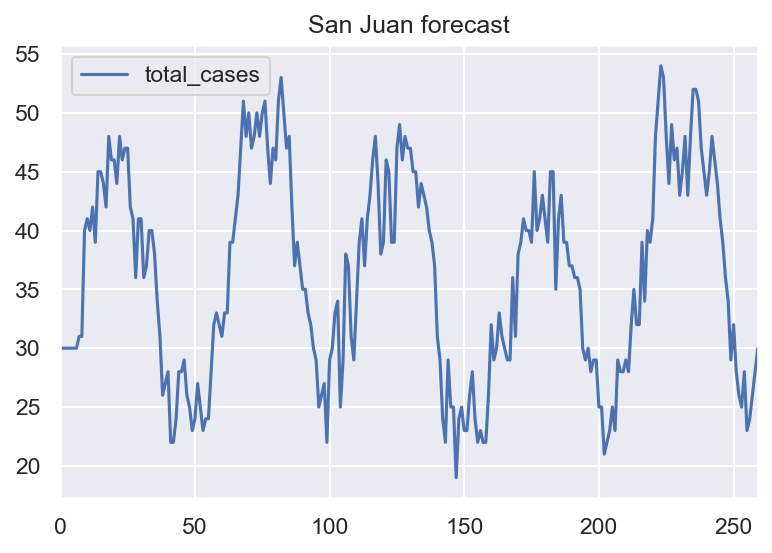

In [41]:
lagf_sub[lagf_sub['city'] == 'sj'].plot(
    y = 'total_cases', 
    title = 'San Juan forecast'
)

Iquitos

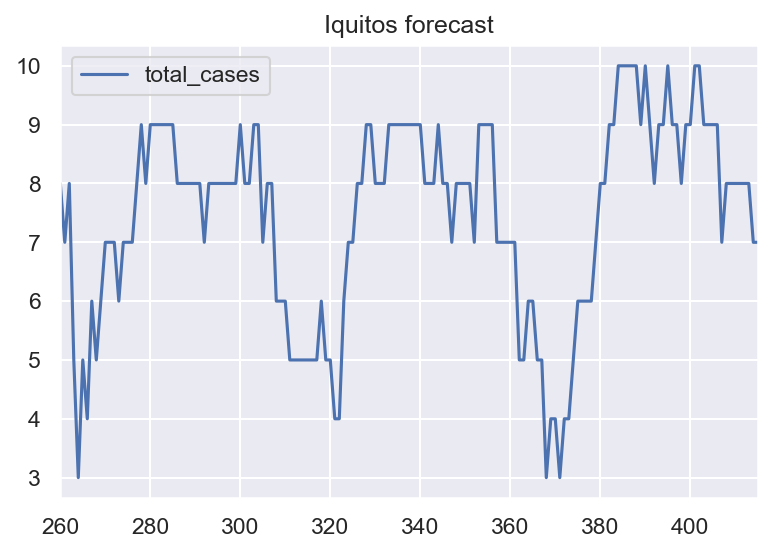

In [42]:
lagf_sub[lagf_sub['city'] == 'iq'].plot(
    y = 'total_cases',
    title = 'Iquitos forecast',
)

#### Leaderboard results

25.73 MAE. A similar performance to our best result using fbprophet.

Using time-lagged features seems to have enabled us to capture the seasonality 
better than in previous linear models